# XGBoost Model for TANAP Boundaries Prediction

This notebook implements and evaluates an XGBoost (Extreme Gradient Boosting) model for predicting TANAP boundaries in historical document scans.

## Model Overview
- **Task**: Multi-class classification (NONE, START, MIDDLE, END)
- **Algorithm**: XGBoost (optimized gradient boosting)
- **Features**: XML layout features + XMI NER features + sequence features
- **Advantages**: High performance, handles missing values, feature importance, regularization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"XGBoost version: {xgb.__version__}")

Libraries imported successfully!
XGBoost version: 3.0.3


## Data Loading and Preprocessing

In [2]:
# Load the feature dataset
df = pd.read_csv('../data/train/features_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nTarget distribution:")
print(df['TANAP Boundaries'].value_counts())
print(f"\nTarget percentages:")
print(df['TANAP Boundaries'].value_counts(normalize=True) * 100)

Dataset shape: (16774, 69)

Target distribution:
TANAP Boundaries
MIDDLE    13058
NONE       1535
START      1091
END        1090
Name: count, dtype: int64

Target percentages:
TANAP Boundaries
MIDDLE    77.846667
NONE       9.151067
START      6.504114
END        6.498152
Name: proportion, dtype: float64


In [3]:
# Prepare features and target
feature_cols = [col for col in df.columns if col not in ['Scan File_Name', 'TANAP Boundaries']]
X = df[feature_cols]
y = df['TANAP Boundaries']

print(f"Number of features: {len(feature_cols)}")

# Handle missing values (XGBoost can handle them, but let's be explicit)
missing_data = X.isnull().sum()
if missing_data.sum() > 0:
    print(f"\nMissing values found:")
    print(missing_data[missing_data > 0])
    # XGBoost handles missing values naturally, but we'll fill for consistency
    X = X.fillna(X.median())
else:
    print("\nNo missing values found.")

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("\nLabel encoding:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{i}: {label}")

Number of features: 67

No missing values found.

Label encoding:
0: END
1: MIDDLE
2: NONE
3: START


In [4]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nTraining set distribution:")
print(pd.Series(y_train).value_counts().sort_index())
print(f"\nTest set distribution:")
print(pd.Series(y_test).value_counts().sort_index())

# Calculate class weights for imbalanced dataset
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print(f"\nClass weights: {class_weight_dict}")

Training set shape: (13419, 67)
Test set shape: (3355, 67)

Training set distribution:
0      872
1    10446
2     1228
3      873
Name: count, dtype: int64

Test set distribution:
0     218
1    2612
2     307
3     218
Name: count, dtype: int64

Class weights: {np.int64(0): np.float64(3.847190366972477), np.int64(1): np.float64(0.3211516369902355), np.int64(2): np.float64(2.7318811074918568), np.int64(3): np.float64(3.8427835051546393)}


## Model Training and Hyperparameter Tuning

In [5]:
# Define hyperparameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Create XGBoost model
xgb_model = xgb.XGBClassifier(
    random_state=42,
    objective='multi:softprob',
    eval_metric='mlogloss',
    n_jobs=-1
)

# Use a smaller grid for faster execution
param_grid_small = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 1.5]
}

print("Starting hyperparameter tuning...")
print("This may take several minutes.")

grid_search = GridSearchCV(
    xgb_model, 
    param_grid, 
    cv=5,  # Reduced CV folds for faster execution
    scoring='f1_weighted', 
    n_jobs=-1, 
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

Starting hyperparameter tuning...
This may take several minutes.
Fitting 5 folds for each of 2187 candidates, totalling 10935 fits

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 1.5, 'subsample': 1.0}
Best CV score: 0.9094


In [6]:
# Train final model with best parameters
best_xgb_model = grid_search.best_estimator_

# Make predictions
y_train_pred = best_xgb_model.predict(X_train)
y_test_pred = best_xgb_model.predict(X_test)

# Get prediction probabilities for analysis
y_test_proba = best_xgb_model.predict_proba(X_test)

# Calculate training and test scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Training F1-score: {train_f1:.4f}")
print(f"Test F1-score: {test_f1:.4f}")

Training Accuracy: 0.9998
Test Accuracy: 0.9136
Training F1-score: 0.9998
Test F1-score: 0.9086


## Model Evaluation

In [7]:
# Detailed classification report
class_names = label_encoder.classes_
print("Classification Report:")
print(classification_report(
    y_test, y_test_pred, 
    target_names=class_names,
    digits=4
))

Classification Report:
              precision    recall  f1-score   support

         END     0.7718    0.5275    0.6267       218
      MIDDLE     0.9374    0.9740    0.9553      2612
        NONE     0.8580    0.8860    0.8718       307
       START     0.7657    0.6147    0.6819       218

    accuracy                         0.9136      3355
   macro avg     0.8332    0.7505    0.7839      3355
weighted avg     0.9082    0.9136    0.9086      3355



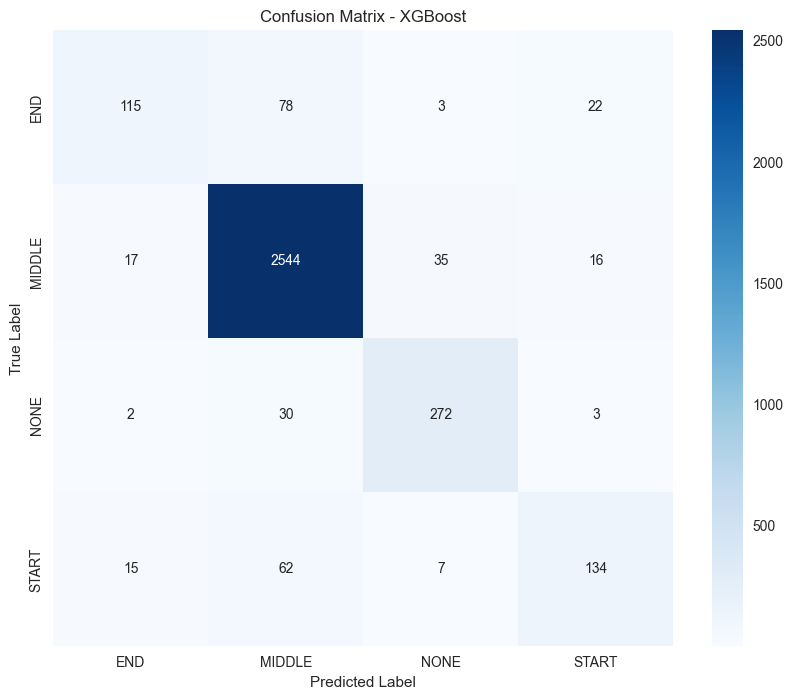


Per-class Metrics:
    Class  Precision  Recall  F1-Score  Support
0     END     0.7718  0.5275    0.6267      218
1  MIDDLE     0.9374  0.9740    0.9553     2612
2    NONE     0.8580  0.8860    0.8718      307
3   START     0.7657  0.6147    0.6819      218


In [8]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_test_pred, average=None
)

metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\nPer-class Metrics:")
print(metrics_df.round(4))

## Feature Importance Analysis

Top 20 Most Important Features:
                     Feature  Importance
2                  num_words    0.212655
1             num_text_lines    0.050256
58     delta_next_num_tokens    0.043770
35       punctuation_density    0.035354
57     delta_prev_num_tokens    0.030833
66       position_normalized    0.030449
43       prev_num_text_lines    0.029107
22        num_named_entities    0.027389
21                num_tokens    0.027158
11         paragraph_regions    0.026116
56           next_num_tokens    0.024446
44       next_num_text_lines    0.023977
65      position_in_sequence    0.023604
32              has_headings    0.022860
33              num_headings    0.021963
38     numeric_content_ratio    0.020473
55           prev_num_tokens    0.019710
8          regions_left_half    0.019529
28             misc_entities    0.017669
53  delta_prev_num_sentences    0.016169


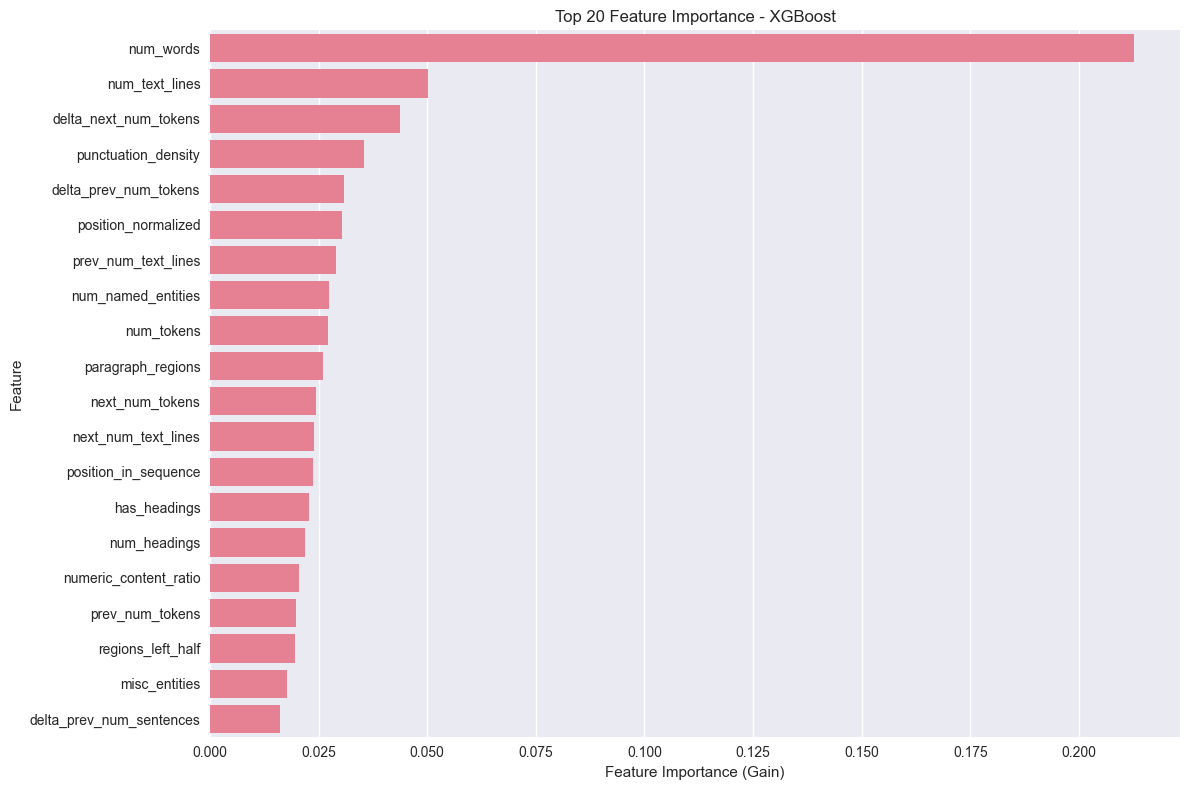

In [9]:
# Get feature importance from XGBoost
feature_importance = best_xgb_model.feature_importances_

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("Top 20 Most Important Features:")
print(feature_importance_df.head(20))

# Plot top features
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(20)
sns.barplot(data=top_features, y='Feature', x='Importance')
plt.title('Top 20 Feature Importance - XGBoost')
plt.xlabel('Feature Importance (Gain)')
plt.tight_layout()
plt.show()

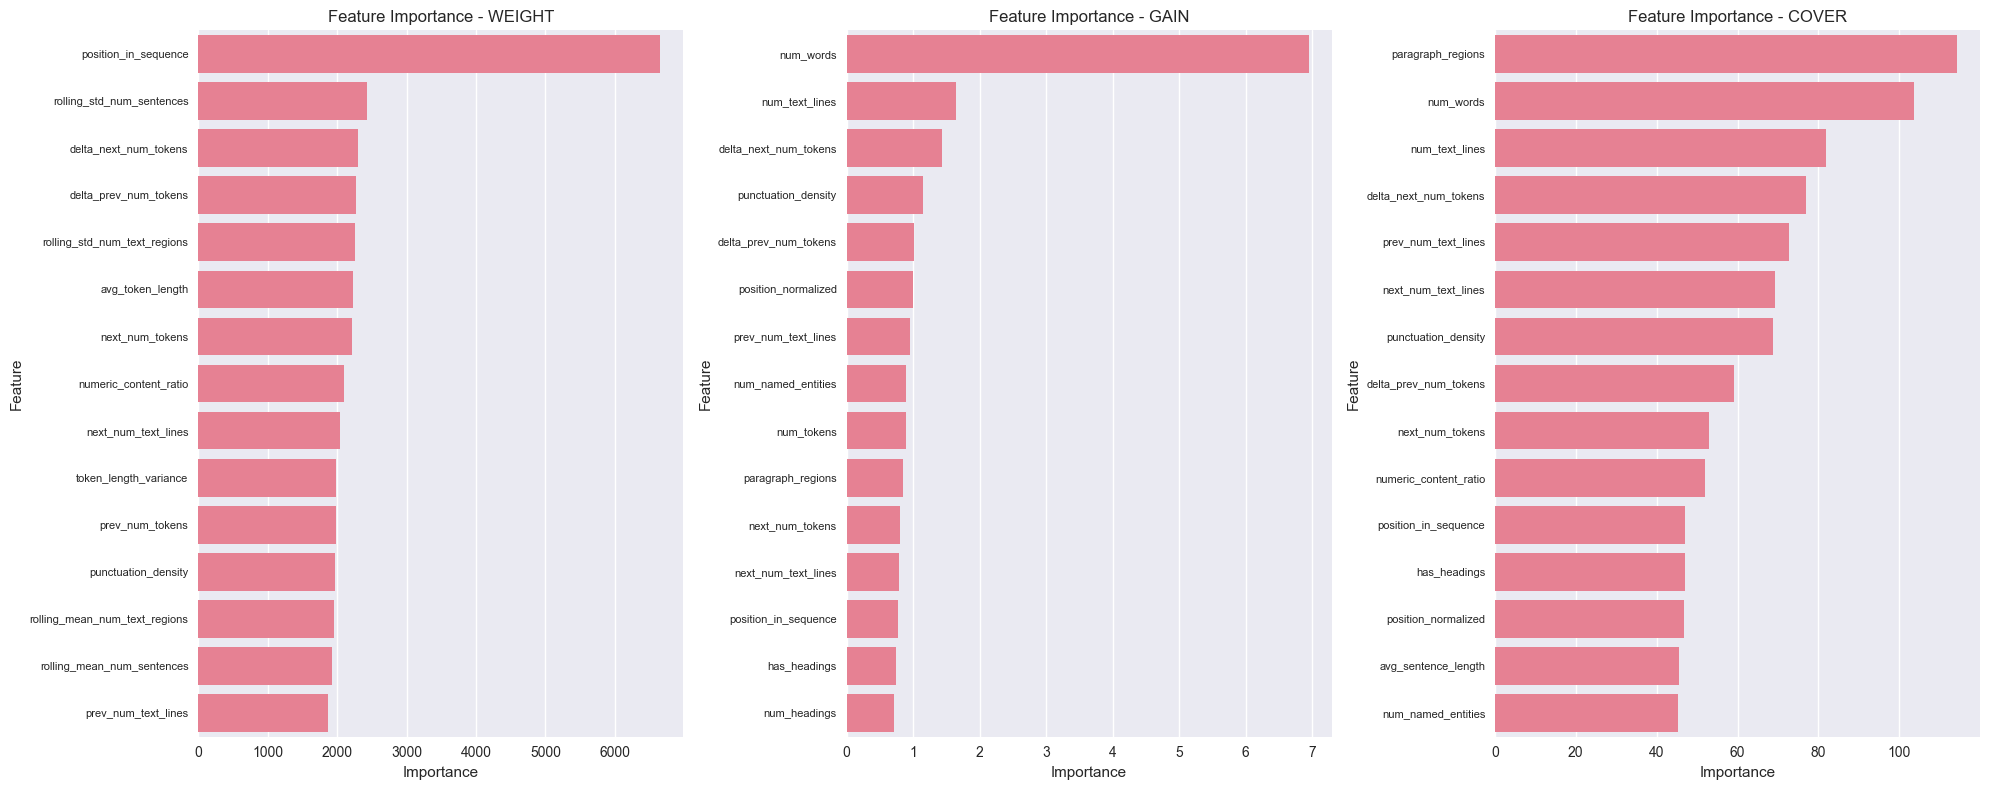


XGBoost Importance Types Explained:
• Weight: Number of times a feature is used to split the data
• Gain: Average gain across all splits using the feature
• Cover: Average coverage across all splits using the feature


In [10]:
# XGBoost provides multiple importance types
importance_types = ['weight', 'gain', 'cover']
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

for idx, importance_type in enumerate(importance_types):
    # Get importance scores
    importance_scores = best_xgb_model.get_booster().get_score(importance_type=importance_type)
    
    # Convert to dataframe and sort
    imp_df = pd.DataFrame(list(importance_scores.items()), columns=['Feature', 'Importance'])
    imp_df = imp_df.sort_values('Importance', ascending=False).head(15)
    
    # Plot
    sns.barplot(data=imp_df, y='Feature', x='Importance', ax=axes[idx])
    axes[idx].set_title(f'Feature Importance - {importance_type.upper()}')
    axes[idx].tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.show()

print("\nXGBoost Importance Types Explained:")
print("• Weight: Number of times a feature is used to split the data")
print("• Gain: Average gain across all splits using the feature")
print("• Cover: Average coverage across all splits using the feature")

## Cross-Validation Analysis

5-Fold Cross-Validation Results:
Accuracy: 0.9144 (+/- 0.0069)
F1-Score: 0.9094 (+/- 0.0071)


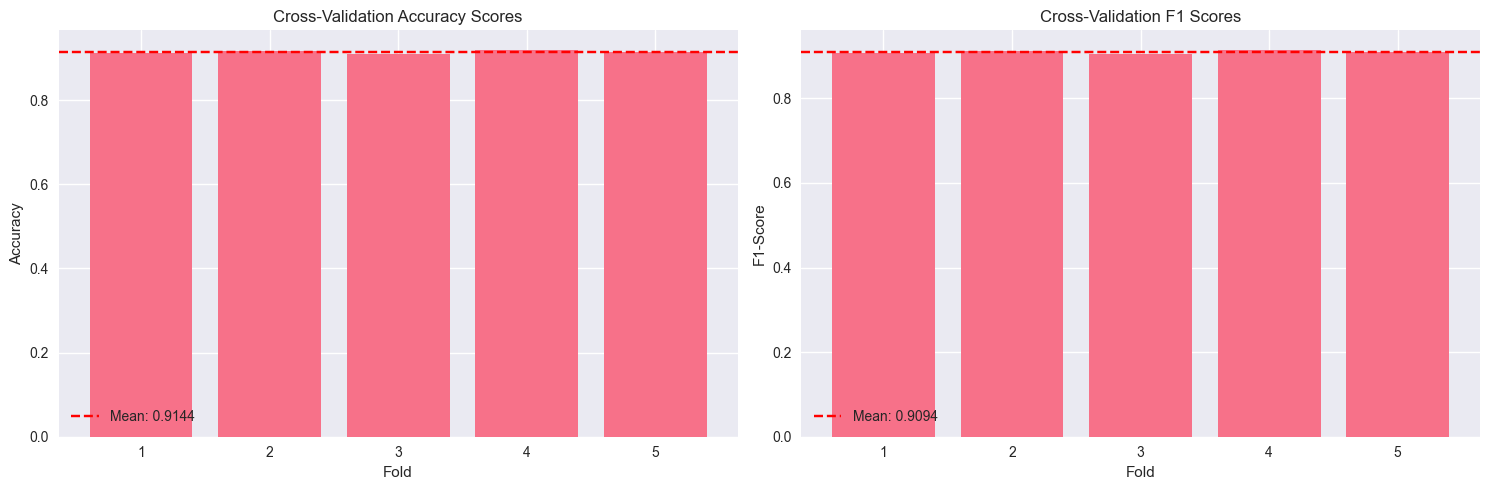

In [11]:
# Perform k-fold cross-validation
cv_scores_accuracy = cross_val_score(
    best_xgb_model, X_train, y_train, cv=5, scoring='accuracy'
)
cv_scores_f1 = cross_val_score(
    best_xgb_model, X_train, y_train, cv=5, scoring='f1_weighted'
)

print("5-Fold Cross-Validation Results:")
print(f"Accuracy: {cv_scores_accuracy.mean():.4f} (+/- {cv_scores_accuracy.std() * 2:.4f})")
print(f"F1-Score: {cv_scores_f1.mean():.4f} (+/- {cv_scores_f1.std() * 2:.4f})")

# Plot CV scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.bar(range(1, 6), cv_scores_accuracy)
ax1.axhline(y=cv_scores_accuracy.mean(), color='r', linestyle='--', 
           label=f'Mean: {cv_scores_accuracy.mean():.4f}')
ax1.set_title('Cross-Validation Accuracy Scores')
ax1.set_xlabel('Fold')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.bar(range(1, 6), cv_scores_f1)
ax2.axhline(y=cv_scores_f1.mean(), color='r', linestyle='--', 
           label=f'Mean: {cv_scores_f1.mean():.4f}')
ax2.set_title('Cross-Validation F1 Scores')
ax2.set_xlabel('Fold')
ax2.set_ylabel('F1-Score')
ax2.legend()

plt.tight_layout()
plt.show()

## Learning Curves and Training Analysis

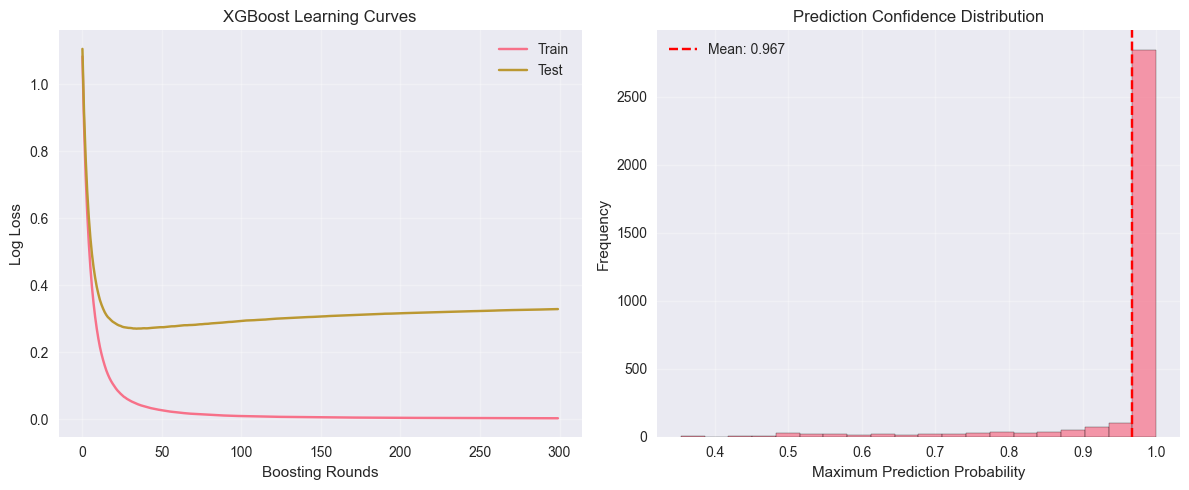


Prediction Confidence Analysis:
Average confidence: 0.9669
Confidence for correct predictions: 0.9794
Confidence for incorrect predictions: 0.8346


In [12]:
# Train model with evaluation to get learning curves
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_names = ['train', 'test']

# Create a new model for evaluation tracking
# Note: eval_metric is set during model initialization for XGBoost 3.x
eval_model = xgb.XGBClassifier(
    **{k: v for k, v in best_xgb_model.get_params().items() if k != 'eval_metric'},
    eval_metric='mlogloss'
)
eval_model.fit(X_train, y_train, 
               eval_set=eval_set, 
               verbose=False)

# Get evaluation results
results = eval_model.evals_result()

# Plot learning curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)
plt.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
plt.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel('Log Loss')
plt.title('XGBoost Learning Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot prediction confidence distribution
plt.subplot(1, 2, 2)
max_probs = np.max(y_test_proba, axis=1)
plt.hist(max_probs, bins=20, alpha=0.7, edgecolor='black')
plt.axvline(np.mean(max_probs), color='red', linestyle='--', 
           label=f'Mean: {np.mean(max_probs):.3f}')
plt.xlabel('Maximum Prediction Probability')
plt.ylabel('Frequency')
plt.title('Prediction Confidence Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze prediction confidence by class
confidence_by_class = pd.DataFrame({
    'True_Class': [class_names[i] for i in y_test],
    'Predicted_Class': [class_names[i] for i in y_test_pred],
    'Confidence': max_probs,
    'Correct': y_test == y_test_pred
})

print("\nPrediction Confidence Analysis:")
print(f"Average confidence: {np.mean(max_probs):.4f}")
print(f"Confidence for correct predictions: {confidence_by_class[confidence_by_class['Correct']]['Confidence'].mean():.4f}")
print(f"Confidence for incorrect predictions: {confidence_by_class[~confidence_by_class['Correct']]['Confidence'].mean():.4f}")

## Model Interpretability - SHAP Analysis (Optional)

<Figure size 1200x800 with 0 Axes>

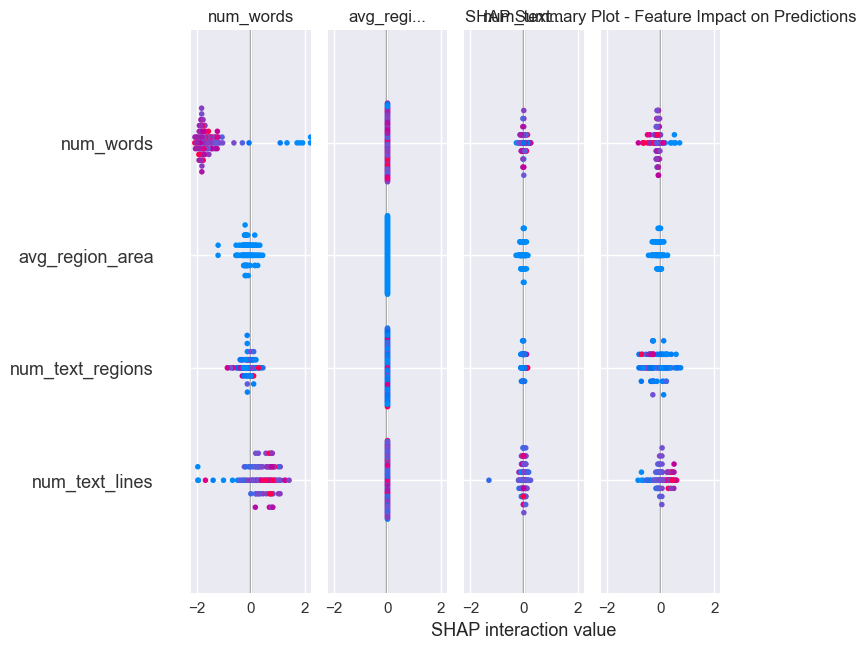

✅ SHAP analysis completed successfully!


In [13]:
# SHAP analysis for model interpretability (if SHAP is available)
try:
    import shap
    
    # Create SHAP explainer
    explainer = shap.TreeExplainer(best_xgb_model)
    
    # Calculate SHAP values for a sample of test data
    sample_size = min(100, len(X_test))
    X_test_sample = X_test.iloc[:sample_size]
    shap_values = explainer.shap_values(X_test_sample)
    
    # Summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample, class_names=class_names, show=False)
    plt.title('SHAP Summary Plot - Feature Impact on Predictions')
    plt.tight_layout()
    plt.show()
    
    print("✅ SHAP analysis completed successfully!")
    
except ImportError:
    print("ℹ️  SHAP not available. Install with: pip install shap")
    print("   SHAP provides advanced model interpretability for XGBoost models.")
except Exception as e:
    print(f"⚠️  SHAP analysis failed: {str(e)}")

## Results Summary and Analysis

In [14]:
# Create comprehensive results summary
results_summary = {
    'Model': 'XGBoost',
    'Best Parameters': grid_search.best_params_,
    'Training Accuracy': train_accuracy,
    'Test Accuracy': test_accuracy,
    'Training F1-Score': train_f1,
    'Test F1-Score': test_f1,
    'CV Accuracy Mean': cv_scores_accuracy.mean(),
    'CV Accuracy Std': cv_scores_accuracy.std(),
    'CV F1-Score Mean': cv_scores_f1.mean(),
    'CV F1-Score Std': cv_scores_f1.std(),
    'Number of Features': len(feature_cols),
    'Number of Estimators': best_xgb_model.n_estimators,
    'Max Depth': best_xgb_model.max_depth,
    'Learning Rate': best_xgb_model.learning_rate,
    'Training Samples': len(X_train),
    'Test Samples': len(X_test),
    'Average Prediction Confidence': np.mean(max_probs),
    'Confidence Correct Predictions': confidence_by_class[confidence_by_class['Correct']]['Confidence'].mean(),
    'Confidence Incorrect Predictions': confidence_by_class[~confidence_by_class['Correct']]['Confidence'].mean()
}

print("XGBOOST MODEL - FINAL RESULTS")
print("=" * 50)
for key, value in results_summary.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

# Analysis and insights
print("\n" + "=" * 50)
print("ANALYSIS AND INSIGHTS")
print("=" * 50)

# Check for overfitting
if train_accuracy - test_accuracy > 0.05:
    print("⚠️  Potential overfitting detected (training accuracy >> test accuracy)")
else:
    print("✅ Good generalization (no significant overfitting)")

# Model performance assessment
if test_accuracy > 0.8:
    print("✅ High model performance (accuracy > 80%)")
elif test_accuracy > 0.7:
    print("⚡ Moderate model performance (accuracy 70-80%)")
else:
    print("⚠️  Low model performance (accuracy < 70%)")

# Prediction confidence assessment
avg_confidence = results_summary['Average Prediction Confidence']
if avg_confidence > 0.8:
    print("✅ High prediction confidence")
elif avg_confidence > 0.6:
    print("⚡ Moderate prediction confidence")
else:
    print("⚠️  Low prediction confidence")

# Confidence difference analysis
conf_diff = results_summary['Confidence Correct Predictions'] - results_summary['Confidence Incorrect Predictions']
if conf_diff > 0.1:
    print("✅ Model shows good confidence calibration (higher confidence for correct predictions)")
else:
    print("⚠️  Model confidence may not be well calibrated")

print(f"\n📊 Most important features for classification:")
for i, (feature, importance) in enumerate(feature_importance_df.head(5).values):
    print(f"   {i+1}. {feature}: {importance:.6f}")

print(f"\n🚀 XGBoost specific insights:")
print(f"   • {best_xgb_model.n_estimators} boosting rounds")
print(f"   • Max tree depth: {best_xgb_model.max_depth}")
print(f"   • Learning rate: {best_xgb_model.learning_rate}")
print(f"   • Subsample ratio: {best_xgb_model.subsample}")
print(f"   • Feature subsample ratio: {best_xgb_model.colsample_bytree}")
print(f"   • L1 regularization: {best_xgb_model.reg_alpha}")
print(f"   • L2 regularization: {best_xgb_model.reg_lambda}")

XGBOOST MODEL - FINAL RESULTS
Model: XGBoost
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 1.5, 'subsample': 1.0}
Training Accuracy: 0.9998
Test Accuracy: 0.9136
Training F1-Score: 0.9998
Test F1-Score: 0.9086
CV Accuracy Mean: 0.9144
CV Accuracy Std: 0.0035
CV F1-Score Mean: 0.9094
CV F1-Score Std: 0.0035
Number of Features: 67
Number of Estimators: 300
Max Depth: 9
Learning Rate: 0.2000
Training Samples: 13419
Test Samples: 3355
Average Prediction Confidence: 0.9668518900871277
Confidence Correct Predictions: 0.9793698191642761
Confidence Incorrect Predictions: 0.8345503211021423

ANALYSIS AND INSIGHTS
⚠️  Potential overfitting detected (training accuracy >> test accuracy)
✅ High model performance (accuracy > 80%)
✅ High prediction confidence
✅ Model shows good confidence calibration (higher confidence for correct predictions)

📊 Most important features for classification:
   1. num_words: 0.21265

## Save Model and Results

In [15]:
import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the model
joblib.dump(best_xgb_model, '../models/xgboost_model.pkl')

# Save XGBoost model in native format (for faster loading)
best_xgb_model.save_model('../models/xgboost_model.json')

# Save results summary
results_df = pd.DataFrame([results_summary])
results_df.to_csv('../models/xgboost_results.csv', index=False)

# Save feature importance
feature_importance_df.to_csv('../models/xgboost_feature_importance.csv', index=False)

# Save confidence analysis
confidence_by_class.to_csv('../models/xgboost_confidence_analysis.csv', index=False)

print("Model and results saved successfully!")
print("Saved files:")
print("  - ../models/xgboost_model.pkl")
print("  - ../models/xgboost_model.json")
print("  - ../models/xgboost_results.csv")
print("  - ../models/xgboost_feature_importance.csv")
print("  - ../models/xgboost_confidence_analysis.csv")

Model and results saved successfully!
Saved files:
  - ../models/xgboost_model.pkl
  - ../models/xgboost_model.json
  - ../models/xgboost_results.csv
  - ../models/xgboost_feature_importance.csv
  - ../models/xgboost_confidence_analysis.csv
